<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrames

(Note: This tutorial is a fork of the official dask tutorial, which you can [find here](https://github.com/dask/dask-tutorial))

In this tutorial, we will use `dask.dataframe` to do parallel operations on dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers `dask.delayed`.


## Install Dask

Let's start by installing dask with:

```
conda install -c conda-forge dask 
```

## Start your own cluster!

dask has many backends, but the one that's most versitile (and often most performant) is the `distributed` backend, so let's use that here. Run:

```python
from dask.distributed import Client
client = Client()
client
```

to create a set of workers on your computer. This cluster is running only on your own computer, but it operates exactly the way it would work on a cloud cluster where these workers live on other computers. 

When you type `client` in a jupyter notebook, you should see the clusters status pop up like this:

![dask_status](../images/dask_status.png)

This status tells me that I have four processes running on my computer, each of which running 4 threads (for 16 cores total). In addition, it tells me that the cluster sees that I have about 34GB of memory for it to play with. 

One cool thing you'll see is that this panel includes a link to a Dashboard. Click this link, and a new tab will open in your browser that shows you, in real time, what your dask cluster is doing! We'll come back to this later.

**Note:** these workers communication via networking protocols, so your firewall / anti-virus may ask if it's ok to let Python accept connections (it is!). If you can't get your system running, it may be due to your firewall / anti-virus. In that case, try `client = Client(processes=False)`. This will create four workers hiding in the same process (obviating the need for network protocols for communication between processes). Don't worry if that last bit doesn't make sense -- those are implementation details you don't ahve to worry about! :)

![dask network warning](../images/dask_firewall.png)

Just authorize Python 3.10!

### Real Data

Lets try this with an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area. To begin, download [NYC Flight data here](https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz), and unzip it somewhere you can find it. 

**(1)** Look at the data in the folder. As you will see it is in many files. Unlike pandas, however, dask can load collections of files all at once. Run `import dask.dataframe as dd`, then using `dd.read_csv` with an asterix wildcard to load all the files at once with something like:

```python
import dask.dataframe as dd
df = dd.read_csv('/users/nick/downloads/nycflights/*.csv',
                 parse_dates={'Date': [0, 1, 2]})
```

(The `parse_dates` option just tells dask that columns 1, 2, and 3 together form a date (they're year, month, and day of the month respectively), and that dask should convert them to a single column called `Date` that is of type datetime. This isn't special to dask, it's just a pandas `read_csv` option.)

**(2)** Look at your dataframe by just calling it (`df`). Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and types.

**(3)** now use `df.head()` to ask dask to actually load a few rows. 

We can view the start and end of the data

**(4)** Now try and run `df.tail()`.

### What just happened?

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns: set `TailNum` to `str`, `CRSElapsedTime` to `float` and `Cancelled` to `bool`.  

## Computations with `dask.dataframe`

Suppose we want to compute the maximum of the `DepDelay` (short for Departure Delays) column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

But this is a far cry from what we do with smaller pandas dataset, which is just

```python
df = pd.read_csv(filename, dtype=dtype)
df.DepDelay.max()
```

To solve this, we can use `dask`! `dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel. To get the maximium value of the column, we can run: 

In [ ]:
%time df.DepDelay.max().compute()

CPU times: user 127 ms, sys: 29.9 ms, total: 157 ms
Wall time: 1.98 s


1435.0

This writes the delayed computation for us and then runs it.  

Some things to note:

1.  Dask uses lazy evaluation, which means it doesn't actually do any work till we call `.compute()`. If you just ran `df.DepDelay.max()`, you'd just get back a placeholder:

```python
> df.DepDelay.max()

dd.Scalar<series-..., dtype=float64>
```

2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
**(5)** Want to know more about what dask is doing? First, just store `df.DepDelay.max()` as a new variable and look at it. Can you see the placeholder? It tells you what it will eventually be (a scalar (single value) float64). But you don't see the actual maximum value. 

**(6)**  You can actually see how dask is developing a plan for getting you the maximum value if you were to run your code right now. We do this with the `.dask` attribute, which you can run on any dask object before you've run `.compute()`.

[For more on task graphs, see here.](https://docs.dask.org/en/stable/graphviz.html#visualize-the-low-level-graph)


## Let's do some manipulations!

In this section we do a few `dask.dataframe` computations. If you are comfortable with Pandas then these should be familiar. You will have to think about when to call `.compute()`. 

When you run `.compute()`, you can also move over to your Dashboard (remember that link in the panel that openned when you created `client`?) to see your cluster working!

**(7)** In total, what is the average delay (`DepDelay`) for non-canceled flights?

**(8)** In total, how many non-cancelled flights were taken from each airport?

*Hint*: use `df.groupby` and `size`.

**(9)** What was the average departure delay from each airport? (`DepDelay`)

**(10)** How many rows are in our dataset?


Note you've probably just found what I think is one of the trickiest things to figure out with a distributed computing system like dask: *some* functions don't follow the rules of delayed evaluation, and when you run them, dask executes immediately. `len` is one of those functions. 

As we'll discuss below, a good rule of thumb is that anything that isn't either (a) a method on the dask dataframe (i.e. something that isn't of the form `df.METHOD()`), or an explicit dask function (something you call from the dask library, like `dd.to_parquet`), it will probably execute immediately. 

`len` is pretty safe since all it returns is a single number, so it's unlikely to blow up your computer if it runs before you want, but you have to be careful with other functions, because if you were to us a pandas function like `pd.to_numeric(df)`, it will execute immediately, and it will do so by pulling all the data into your client session as a single giant dataframe, and with a larger dataset, it is likely to crash you computer when you do so. 

An alternative that *won't* execute until you run `compute` is `df.shape[0]` (see how it takes the form of a method on our dask dataframe `df`?) Try it to see!

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [ ]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [ ]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 376 ms, sys: 43.4 ms, total: 419 ms
Wall time: 3.88 s


But lets try by passing both to a single `compute` call.

In [ ]:
import dask

In [ ]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 237 ms, sys: 26.5 ms, total: 264 ms
Wall time: 2 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to zoom in on the graph better):

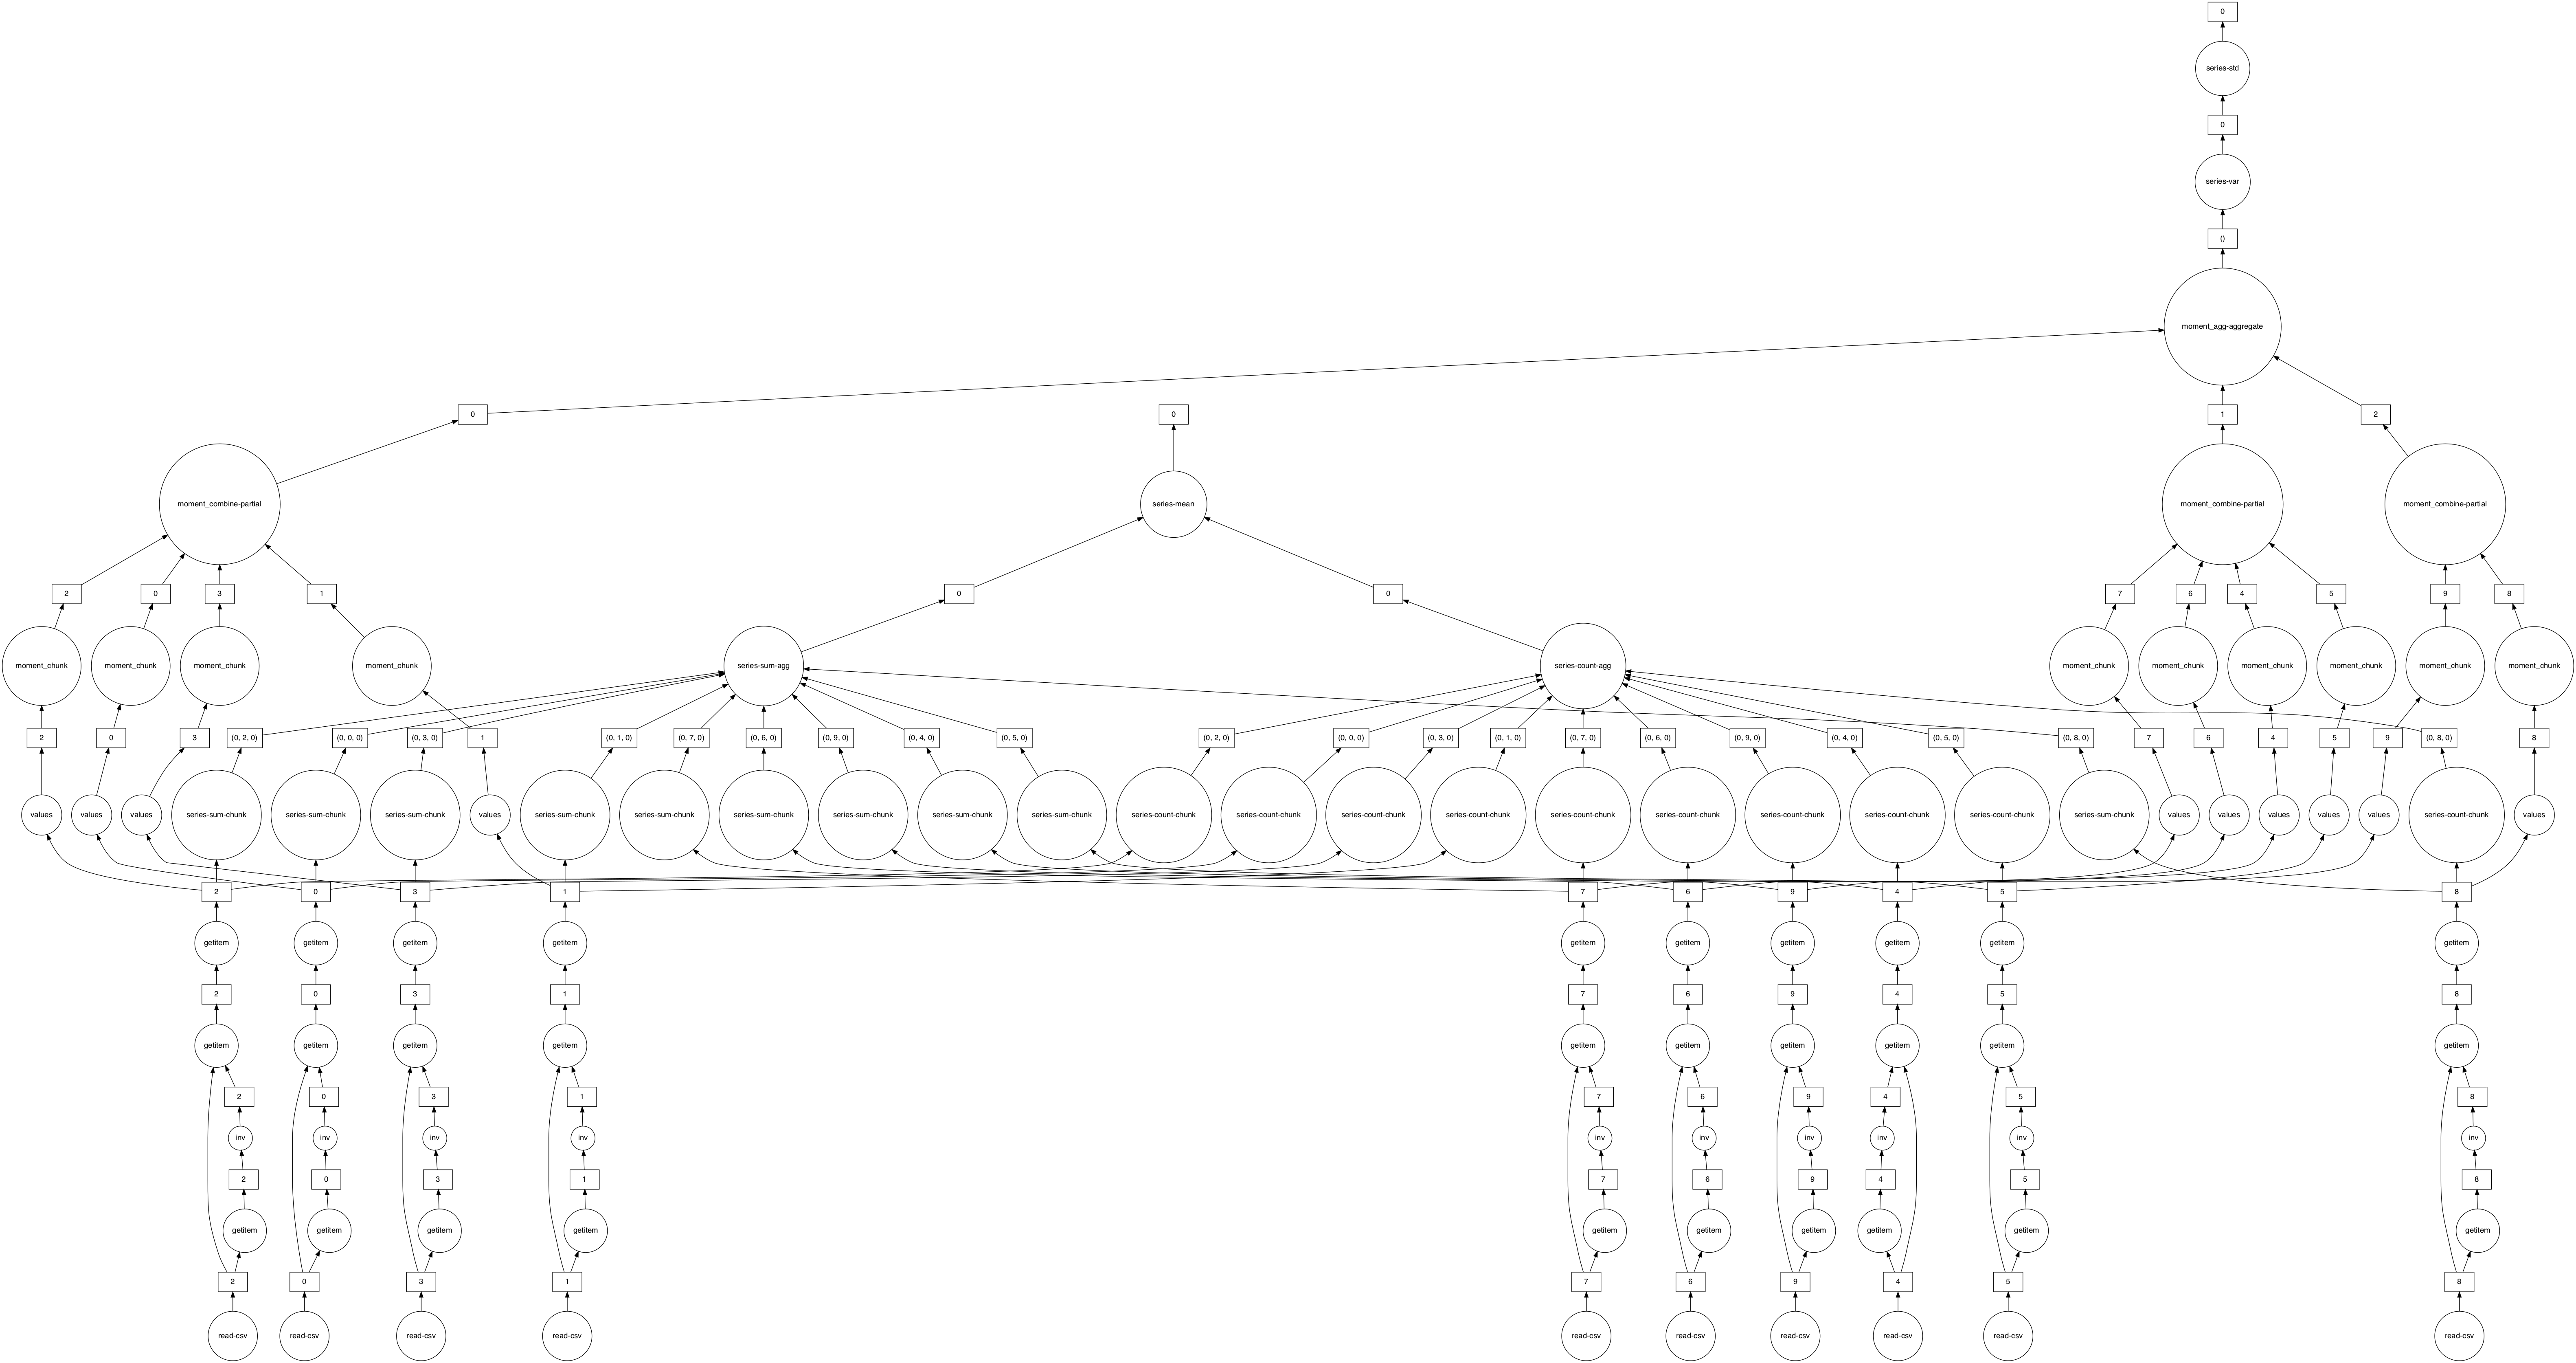

In [ ]:
dask.visualize(mean_delay, std_delay)

But lets try by passing both to a single `compute` call.

**(11)** Now you try -- for each airport, get both the average delay and the maximum delay in the data for flights that weren't cancelled. 

(As another example of places that distributed computing gets tricky, while it's easy to do means and maxes, you can't easily get the median of a group (e.g.`df.groupby('Origin)['DepDelay'].median()`) in a distributed manner. There are workarounds, but these are the kinds of "fragile" things that make distributed computing a bit of a pain). 

## Converting Scheduled Departure Time (`CRSDepTime`) to a timestamp

This dataset stores the scheduled departure times of flights in the format `HHMM`, which are read in as integers in `read_csv`:

In [ ]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

To combine the data we have on flight dates with these departure times into a single column that includes all that information in a single `datetime` format, we have to convert the time of day into a Timedelta type, then add those Timedeltas to our Date column to get a single column that knows the date AND time of day of departures. (Implicitly, dates think of themselves as living at midnight, so adding a timedelta of 10 hours moves them to 10am). 

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [ ]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

## Other Things to Know

### Persist (caching)

Sometimes you want your computers to keep intermediate results in memory (when it's possible). To "cache" data in this manner, you can to use the `persist()` method to tell dask what results you want to keep around. You can read [more here](https://docs.dask.org/en/latest/dataframe-best-practices.html#persist-intelligently).

### Using Parquet

Dask works really efficiently with data stored in parquet format, [as noted here](https://docs.dask.org/en/latest/dataframe-best-practices.html#store-data-in-apache-parquet-format), so keeping data in parquet (as I've [suggested you do anyway](../parquet.ipynb)!) will help you with dask.

## Limitations

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial shuffling of data, and may write out to disk.

### What definitely works?

* Trivially parallelizable operations (fast):
    *  Elementwise operations:  ``df.x + df.y``
    *  Row-wise selections:  ``df[df.x > 0]``
    *  Loc:  ``df.loc[4.0:10.5]``
    *  Common aggregations:  ``df.x.max()``
    *  Is in:  ``df[df.x.isin([1, 2, 3])]``
    *  Datetime/string accessors:  ``df.timestamp.month``
* Cleverly parallelizable operations (also fast):
    *  groupby-aggregate (with common aggregations): ``df.groupby(df.x).y.max()``
    *  value_counts:  ``df.x.value_counts``
    *  Drop duplicates:  ``df.x.drop_duplicates()``
    *  Join on index:  ``dd.merge(df1, df2, left_index=True, right_index=True)``
* Operations requiring a shuffle (slow-ish, unless on index)
    *  Set index:  ``df.set_index(df.x)``
    *  groupby-apply (with anything):  ``df.groupby(df.x).apply(myfunc)``
    *  Join not on the index:  ``pd.merge(df1, df2, on='name')``
* Ingest operations
    *  Files: ``dd.read_csv, dd.read_parquet, dd.read_json, dd.read_orc``, etc.
    *  Pandas: ``dd.from_pandas``
    *  Anything supporting numpy slicing: ``dd.from_array``
    *  From any set of functions creating sub dataframes via ``dd.from_delayed``.
    *  Dask.bag: ``mybag.to_dataframe(columns=[...])``